In [1]:
 %matplotlib inline
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('./KB_mxxg/comb_pre_to_cat2.csv')

In [3]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], 1)

In [4]:
def gucode(path):
    gucode = {}
    df = pd.read_csv(path, sep=':',names=['name', 'code'])
    for i,code in enumerate(df['code']):
        gucode[code] = df['name'][i]
    return gucode

gucode = gucode('./KB_mxxg/gucode.txt')

In [5]:
gucode

{11110: '종로구',
 11140: '중구',
 11170: '용산구',
 11200: '성동구',
 11215: '광진구',
 11230: '동대문구',
 11260: '중랑구',
 11290: '성북구',
 11305: '강북구',
 11320: '도봉구',
 11350: '노원구',
 11380: '은평구',
 11410: '서대문구',
 11440: '마포구',
 11470: '양천구',
 11500: '강서구',
 11530: '구로구',
 11545: '금천구',
 11560: '영등포구',
 11590: '동작구',
 11620: '관악구',
 11650: '서초구',
 11680: '강남구',
 11710: '송파구',
 11740: '강동구'}

In [6]:
def idx_custom(custom_data, year_range, year_idx, code):
    custom_data = custom_data.iloc[year_idx]
    custom_data = custom_data.reset_index(drop=True)
    print('Only {} data in {} year(s)'.format(gucode[code], year_range))
    print('Data size : {}'.format(len(custom_data)))
    
    return custom_data, gucode[code]

In [7]:
def custom_data(code):
    #input gu-code & year
    min_year = int(input('start year: '))
    max_year = int(input('end year: '))
    
    gu_idx = np.where(data[str(code)]==1)[0]
    
    custom_data = data.iloc[gu_idx] #원하는 구만 잘라냄
    custom_data = custom_data.reset_index(drop=True) #index 0부터 다시 초기화
    year_range = []
    
    if max_year >= min_year:
        
        for year in range(min_year, max_year + 1):
            year_range.append(year)
            
        tmp = [np.where(custom_data['d_yr'] == year)[0] for year in year_range]
        year_idx = np.concatenate(tmp)

        return idx_custom(custom_data, year_range, year_idx, code)
        
    elif max_year == min_year:
        year_range.append(min_year)
        year_idx = np.where(custom_data['d_yr'] == year_range[0])[0]
        
        return idx_custom(custom_data,year_range, year_idx, code)
    else:
        return 0
    

In [8]:
songpa, gu_name = custom_data(11710)

start year: 2010
end year: 2018
Only 송파구 data in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] year(s)
Data size : 91363


In [9]:
def datasplit(data):
    data = data.sample(frac=1).reset_index(drop=True) #shuffle
    data = data.reset_index(drop=True) #index 초기화
    
    train_len = int(len(data)*0.8)
    
    train = data.loc[:train_len-1]
    train = train.sample(frac=1).reset_index(drop=True) #shuffle
    train = train.reset_index(drop=True) #index 초기화
    
    test = data.loc[train_len:]
    test = test.sample(frac=1).reset_index(drop=True) #shuffle
    test = test.reset_index(drop=True)
    
    print ('{} data is splitted into {} train / {} test data'.format(len(data),len(train), len(test)))
    return train, test

In [10]:
train, test = datasplit(songpa)

91363 data is splitted into 73090 train / 18273 test data


In [11]:
def make_x_y(data):
    x = data.drop(['price', 'avg_price'],1)
    y = data['price'].values
    
    print('Done')
    return x,y

In [12]:
x_train, y_train = make_x_y(train)
x_test, y_test = make_x_y(test)

Done
Done


/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


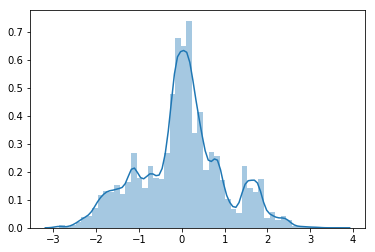

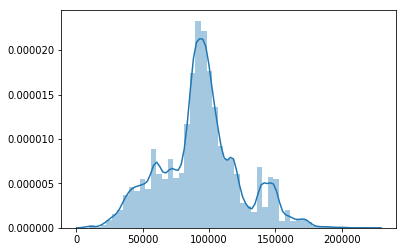

In [13]:
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y_train) #정규분포화
yt2 = johnson_inverse(yt, g, et, ep, l) #inverse 정규분포화
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers,optimizers,losses
from keras.layers.normalization import BatchNormalization

import datetime
import os

Using TensorFlow backend.


In [15]:
# path where all models are saved
now = datetime.datetime.now()
ymd = (str(now.year) + str(now.month) + str(now.day))

BASE_PATH = './'+gu_name+'_model_'+ymd+'/'
MODEL_NAME = 'MLP_rmse'
CURR_PATH = BASE_PATH + MODEL_NAME + "/"

if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50)

In [16]:
def custom_loss(y_true,y_pred):
    import keras.backend as K
    #loss = K.mean((y_true - y_pred)**2, axis=-1)
    loss = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''
    def _logcosh(x):
        return x + K.softplus(-2. * x) - K.log(2.)
    loss= K.mean(_logcosh(y_pred - y_true), axis=-1)
    '''
    return loss

In [17]:
def rmse(y_true,y_pred):
    import keras.backend as K
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [18]:
def rmsle(y_true, y_pred):
    import keras.backend as K
    first_log = K.log(y_pred + 1)
    second_log = K.log(y_true + 1)
    loss= K.sqrt(K.mean(K.square(first_log - second_log)))
    return loss

In [19]:
def rmsle_for_eval(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log(y_pred+1)-np.log(y_true+1))))

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
adam = optimizers.Adam(lr=0.0009, decay=0.0001)

In [22]:
def Model(x_train, y_train, batch_size, max_epochs):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=114))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=adam,
                  loss=rmse,
                  metrics=['accuracy'])

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    # Validation_split으로 validation 얼마나 해줄건지 정해중!
    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=max_epochs,
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[checkloss, early_stopping])
    
    return model, history

In [24]:
model = Model(x_train, yt, 32, 5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               14720     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
__________

65781/65781 [==============================] - 8s 118us/step - loss: 0.2712 - acc: 0.0000e+00 - val_loss: 0.2628 - val_acc: 0.0000e+00

Epoch 00029: val_loss did not improve from 0.22465
Epoch 30/5000
65781/65781 [==============================] - 8s 119us/step - loss: 0.2695 - acc: 0.0000e+00 - val_loss: 0.2514 - val_acc: 0.0000e+00

Epoch 00030: val_loss did not improve from 0.22465
Epoch 31/5000
65781/65781 [==============================] - 8s 120us/step - loss: 0.2692 - acc: 0.0000e+00 - val_loss: 0.2517 - val_acc: 0.0000e+00

Epoch 00031: val_loss did not improve from 0.22465
Epoch 32/5000
65781/65781 [==============================] - 8s 121us/step - loss: 0.2677 - acc: 0.0000e+00 - val_loss: 0.2146 - val_acc: 0.0000e+00

Epoch 00032: val_loss improved from 0.22465 to 0.21464, saving model to ./송파구_model_20181117/MLP_rmse/val_loss-0.214643.hdf5
Epoch 33/5000
65781/65781 [==============================] - 8s 121us/step - loss: 0.2691 - acc: 0.0000e+00 - val_loss: 0.2447 - val_acc

65781/65781 [==============================] - 8s 119us/step - loss: 0.2575 - acc: 0.0000e+00 - val_loss: 0.2217 - val_acc: 0.0000e+00

Epoch 00068: val_loss did not improve from 0.18977
Epoch 69/5000
65781/65781 [==============================] - 8s 122us/step - loss: 0.2567 - acc: 0.0000e+00 - val_loss: 0.1963 - val_acc: 0.0000e+00

Epoch 00069: val_loss did not improve from 0.18977
Epoch 70/5000
65781/65781 [==============================] - 8s 120us/step - loss: 0.2554 - acc: 0.0000e+00 - val_loss: 0.1907 - val_acc: 0.0000e+00

Epoch 00070: val_loss did not improve from 0.18977
Epoch 71/5000
65781/65781 [==============================] - 8s 119us/step - loss: 0.2560 - acc: 0.0000e+00 - val_loss: 0.2063 - val_acc: 0.0000e+00

Epoch 00071: val_loss did not improve from 0.18977
Epoch 72/5000
65781/65781 [==============================] - 8s 121us/step - loss: 0.2574 - acc: 0.0000e+00 - val_loss: 0.1904 - val_acc: 0.0000e+00

Epoch 00072: val_loss did not improve from 0.18977
Epoch 73/

65781/65781 [==============================] - 8s 126us/step - loss: 0.2496 - acc: 0.0000e+00 - val_loss: 0.1843 - val_acc: 0.0000e+00

Epoch 00107: val_loss did not improve from 0.18106
Epoch 108/5000
65781/65781 [==============================] - 8s 125us/step - loss: 0.2469 - acc: 0.0000e+00 - val_loss: 0.1806 - val_acc: 0.0000e+00

Epoch 00108: val_loss improved from 0.18106 to 0.18060, saving model to ./송파구_model_20181117/MLP_rmse/val_loss-0.180601.hdf5
Epoch 109/5000
65781/65781 [==============================] - 8s 126us/step - loss: 0.2473 - acc: 0.0000e+00 - val_loss: 0.1972 - val_acc: 0.0000e+00

Epoch 00109: val_loss did not improve from 0.18060
Epoch 110/5000
65781/65781 [==============================] - 8s 123us/step - loss: 0.2546 - acc: 0.0000e+00 - val_loss: 0.1998 - val_acc: 0.0000e+00

Epoch 00110: val_loss did not improve from 0.18060
Epoch 111/5000
65781/65781 [==============================] - 8s 124us/step - loss: 0.2486 - acc: 0.0000e+00 - val_loss: 0.1932 - val

65781/65781 [==============================] - 8s 124us/step - loss: 0.2450 - acc: 0.0000e+00 - val_loss: 0.2018 - val_acc: 0.0000e+00

Epoch 00147: val_loss did not improve from 0.18060
Epoch 148/5000
65781/65781 [==============================] - 8s 125us/step - loss: 0.2460 - acc: 0.0000e+00 - val_loss: 0.1831 - val_acc: 0.0000e+00

Epoch 00148: val_loss did not improve from 0.18060
Epoch 149/5000
65781/65781 [==============================] - 8s 122us/step - loss: 0.2488 - acc: 0.0000e+00 - val_loss: 0.1977 - val_acc: 0.0000e+00

Epoch 00149: val_loss did not improve from 0.18060
Epoch 150/5000
65781/65781 [==============================] - 8s 125us/step - loss: 0.2460 - acc: 0.0000e+00 - val_loss: 0.1877 - val_acc: 0.0000e+00

Epoch 00150: val_loss did not improve from 0.18060
Epoch 151/5000
65781/65781 [==============================] - 8s 125us/step - loss: 0.2435 - acc: 0.0000e+00 - val_loss: 0.2035 - val_acc: 0.0000e+00

Epoch 00151: val_loss did not improve from 0.18060
Epoch

65781/65781 [==============================] - 8s 125us/step - loss: 0.2427 - acc: 0.0000e+00 - val_loss: 0.1790 - val_acc: 0.0000e+00

Epoch 00187: val_loss did not improve from 0.17672
Epoch 188/5000
65781/65781 [==============================] - 8s 123us/step - loss: 0.2469 - acc: 0.0000e+00 - val_loss: 0.1857 - val_acc: 0.0000e+00

Epoch 00188: val_loss did not improve from 0.17672
Epoch 189/5000
65781/65781 [==============================] - 8s 124us/step - loss: 0.2441 - acc: 0.0000e+00 - val_loss: 0.1845 - val_acc: 0.0000e+00

Epoch 00189: val_loss did not improve from 0.17672
Epoch 190/5000
65781/65781 [==============================] - 8s 124us/step - loss: 0.2409 - acc: 0.0000e+00 - val_loss: 0.1849 - val_acc: 0.0000e+00

Epoch 00190: val_loss did not improve from 0.17672
Epoch 191/5000
65781/65781 [==============================] - 8s 123us/step - loss: 0.2440 - acc: 0.0000e+00 - val_loss: 0.1793 - val_acc: 0.0000e+00

Epoch 00191: val_loss did not improve from 0.17672
Epoch

In [25]:
def plot_train(history):
    fig, loss_ax = plt.subplots(figsize=(10,10))

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')


    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')

    loss_ax.legend(loc='upper right')

    plt.show()
    
def test_summary(model, weight_path):
    plot_train(model[1]) #history = moedl[1]
    model[0].load_weights(weight_path) #model = model[0]
    norm_y = g + et*np.arcsinh((y_test-ep)/l)
    loss, acc = model[0].evaluate(x_test, norm_y, batch_size=32)
    #loss, acc = model[0].evaluate(x_test, y_test, batch_size=32)
    print('----- Evaluation loss and metrics -----')
    print('Test loss - RMSE : {:.5f}'.format(loss))
    
    
def save_model(model, path, gu_name):
    model_json = model[0].to_json()
    
    file_name = path+gu_name+'_model.json'
    print(file_name)
    with open(file_name, "w") as json_file : 
        json_file.write(model_json)
        
def load_model(path, gu_name):
    from keras.models import model_from_json
    
    file_name = path+gu_name+'_model.json'
    
    json_file = open(file_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    return loaded_model

In [26]:
def get_best_weights_path():
    return CURR_PATH + sorted(os.listdir(CURR_PATH))[0]

In [27]:
FULL_PATH = get_best_weights_path()
print(FULL_PATH)

./송파구_model_20181117/MLP_rmse/val_loss-0.176720.hdf5


In [28]:
save_model(model, CURR_PATH, gu_name)

./송파구_model_20181117/MLP_rmse/송파구_model.json


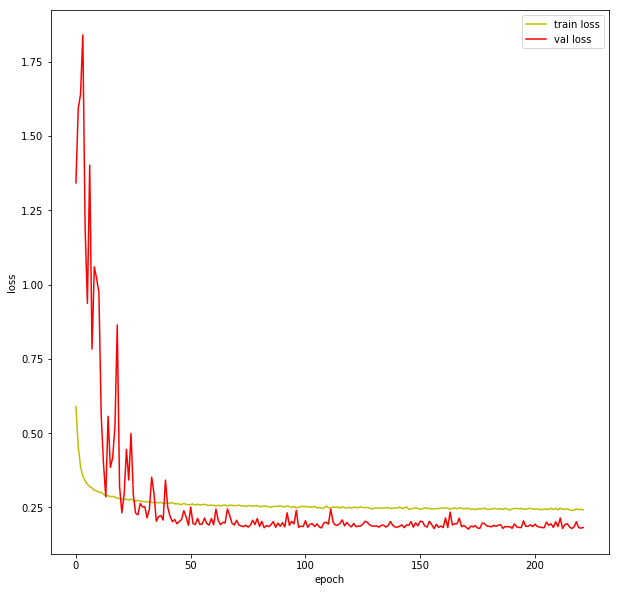

18273/18273 [==============================] - 1s 39us/step
----- Evaluation loss and metrics -----
Test loss - RMSE : 0.17236


In [29]:
test_summary(model,FULL_PATH)

In [30]:
def prediction_plot(n_sample):
    from sklearn.metrics import r2_score

    randidx = np.random.choice(len(x_test), n_sample, replace=False)
  
    
    y_pred = model[0].predict(x_test).flatten()
    y_pred = johnson_inverse(y_pred, g, et, ep, l)
    
    _y_pred = y_pred[randidx]
    y_sample = y_test[randidx]

    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

    index = np.arange(n_sample)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax0.bar(index, y_sample, bar_width, alpha=opacity, color='b',label='GT')
    rects2 = ax0.bar(index + bar_width, _y_pred, bar_width, alpha=opacity, color='r',label='Pred')

    ax0.set_xlabel('Data')
    ax0.set_ylabel('Price')
    ax0.set_title('Difference between GT/Pred - {}'.format(gu_name))
    ax0.legend()

    
    loss = rmsle_for_eval(y_test, y_pred)

    lower_bound = int(y_test.min())-10000
    higher_bound = int(y_test.max())+10000
    
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    
    ax1.scatter(y_test, y_pred, alpha=opacity, color='g')
    ax1.plot([lower_bound, higher_bound], [lower_bound, higher_bound], '--k')
    ax1.set_ylabel('Pred')
    ax1.set_xlabel('GT')
    ax1.set_title('Regression - {}'.format(gu_name))
    ax1.text(lower_bound+25000, lower_bound+15000, r'$R^2$={:.2f}, RMSLE={:.5f}'.format(r2_score(y_test, y_pred),loss))
    ax1.set_xlim([lower_bound, higher_bound])
    ax1.set_ylim([lower_bound, higher_bound])
    
    fig.tight_layout()
    plt.show()
    
    diff = abs(y_pred-y_test)
    print('Max difference : {:.2f} 만원'.format(diff.max()))
    print('Mean difference : {:.2f} 만원'.format(diff.mean()))
    print('--------')
    print('Avg Price of {}: {:.2f} 만원'.format(gu_name,y_test.mean()))
    print('--------')
    print('R2 Coefficient : {:.3f}'.format(r2_score(y_test, y_pred)))
    print('RMLSE loss : {:.4f}'.format(loss))
    print('MAPE : {:.4f}' .format(mape))
    return y_pred, diff

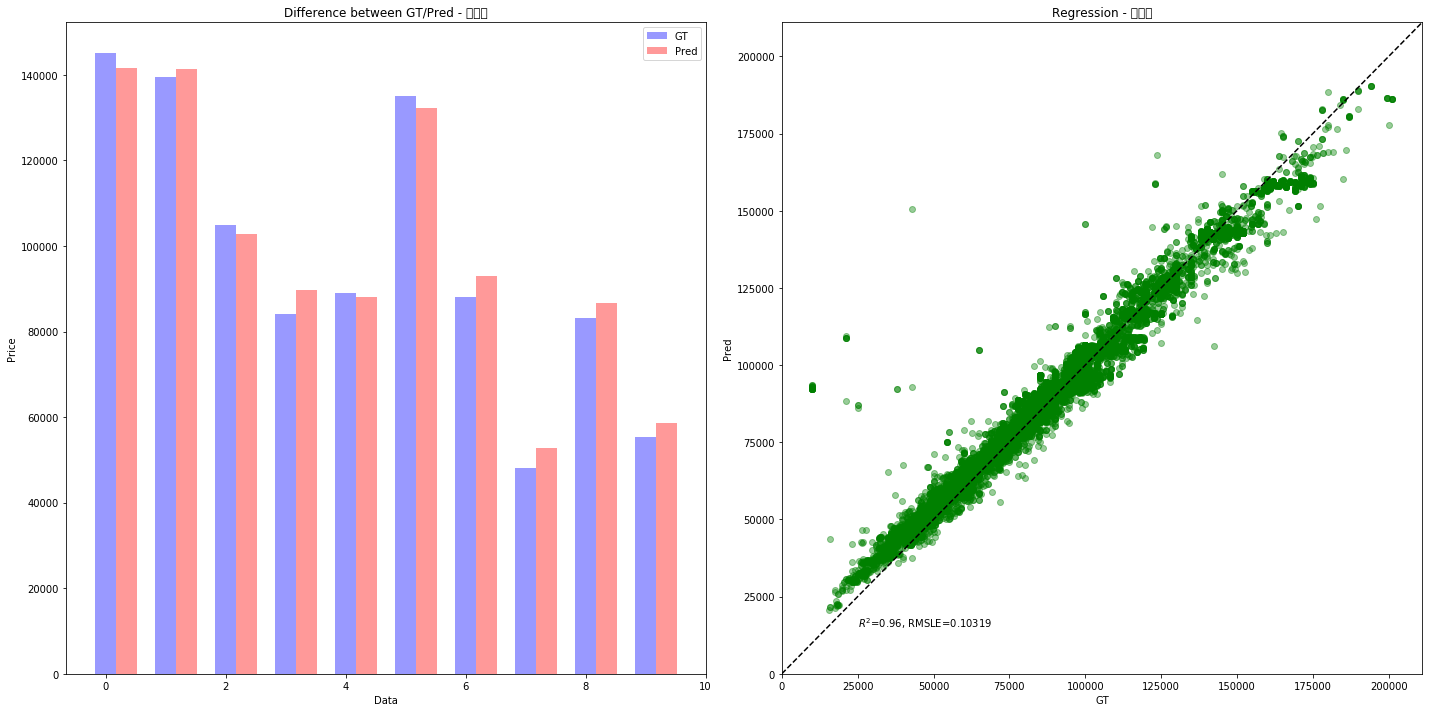

Max difference : 107585.36 만원
Mean difference : 3782.91 만원
--------
Avg Price of 송파구: 93898.26 만원
--------
R2 Coefficient : 0.963
RMLSE loss : 0.1032
MAPE : 5.6613


In [31]:
y_pred, diff = prediction_plot(10)

In [32]:
def run_loaded_model(model, x_train, y_train, batch_size, max_epochs):
    model.compile(optimizer=adam,
                  loss=rmse,
                  metrics=['accuracy'])
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=max_epochs,
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[checkloss, early_stopping])
    
    return model, history

In [33]:
loaded_model = load_model(CURR_PATH, gu_name)
FULL_PATH = get_best_weights_path()
loaded_model.load_weights(FULL_PATH)

In [35]:
model = run_loaded_model(loaded_model, x_train, yt, 32, 1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               14720     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
__________


Epoch 00031: val_loss did not improve from 0.17856
Epoch 32/1000
65781/65781 [==============================] - 9s 130us/step - loss: 0.2450 - acc: 0.0000e+00 - val_loss: 0.1899 - val_acc: 0.0000e+00

Epoch 00032: val_loss did not improve from 0.17856
Epoch 33/1000
65781/65781 [==============================] - 9s 129us/step - loss: 0.2428 - acc: 0.0000e+00 - val_loss: 0.1840 - val_acc: 0.0000e+00

Epoch 00033: val_loss did not improve from 0.17856
Epoch 34/1000
65781/65781 [==============================] - 9s 129us/step - loss: 0.2431 - acc: 0.0000e+00 - val_loss: 0.1850 - val_acc: 0.0000e+00

Epoch 00034: val_loss did not improve from 0.17856
Epoch 35/1000
65781/65781 [==============================] - 9s 129us/step - loss: 0.2455 - acc: 0.0000e+00 - val_loss: 0.1896 - val_acc: 0.0000e+00

Epoch 00035: val_loss did not improve from 0.17856
Epoch 36/1000
65781/65781 [==============================] - 8s 128us/step - loss: 0.2429 - acc: 0.0000e+00 - val_loss: 0.1838 - val_acc: 0.0000

65781/65781 [==============================] - 8s 129us/step - loss: 0.2419 - acc: 0.0000e+00 - val_loss: 0.1858 - val_acc: 0.0000e+00

Epoch 00072: val_loss did not improve from 0.17502
Epoch 73/1000
65781/65781 [==============================] - 8s 128us/step - loss: 0.2423 - acc: 0.0000e+00 - val_loss: 0.1789 - val_acc: 0.0000e+00

Epoch 00073: val_loss did not improve from 0.17502
Epoch 74/1000
65781/65781 [==============================] - 8s 129us/step - loss: 0.2416 - acc: 0.0000e+00 - val_loss: 0.1854 - val_acc: 0.0000e+00

Epoch 00074: val_loss did not improve from 0.17502
Epoch 75/1000
65781/65781 [==============================] - 9s 130us/step - loss: 0.2417 - acc: 0.0000e+00 - val_loss: 0.1847 - val_acc: 0.0000e+00

Epoch 00075: val_loss did not improve from 0.17502
Epoch 76/1000
65781/65781 [==============================] - 8s 128us/step - loss: 0.2397 - acc: 0.0000e+00 - val_loss: 0.1944 - val_acc: 0.0000e+00

Epoch 00076: val_loss did not improve from 0.17502
Epoch 77/

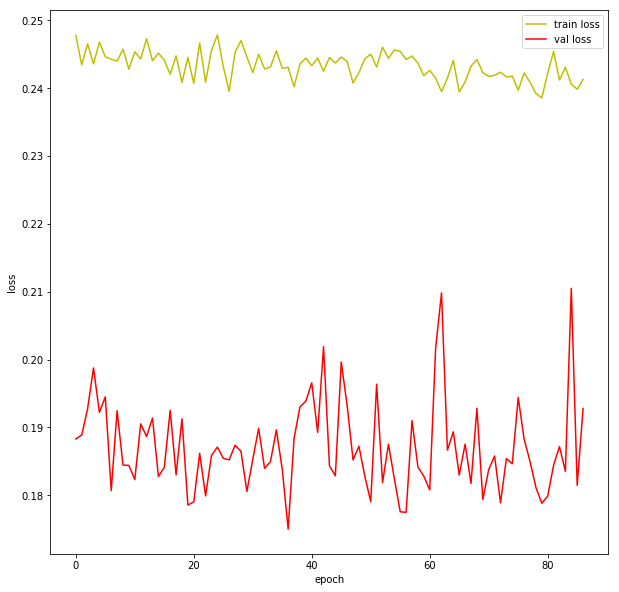

18273/18273 [==============================] - 1s 33us/step
----- Evaluation loss and metrics -----
Test loss - RMSE : 0.17236


In [36]:
test_summary(model,FULL_PATH)

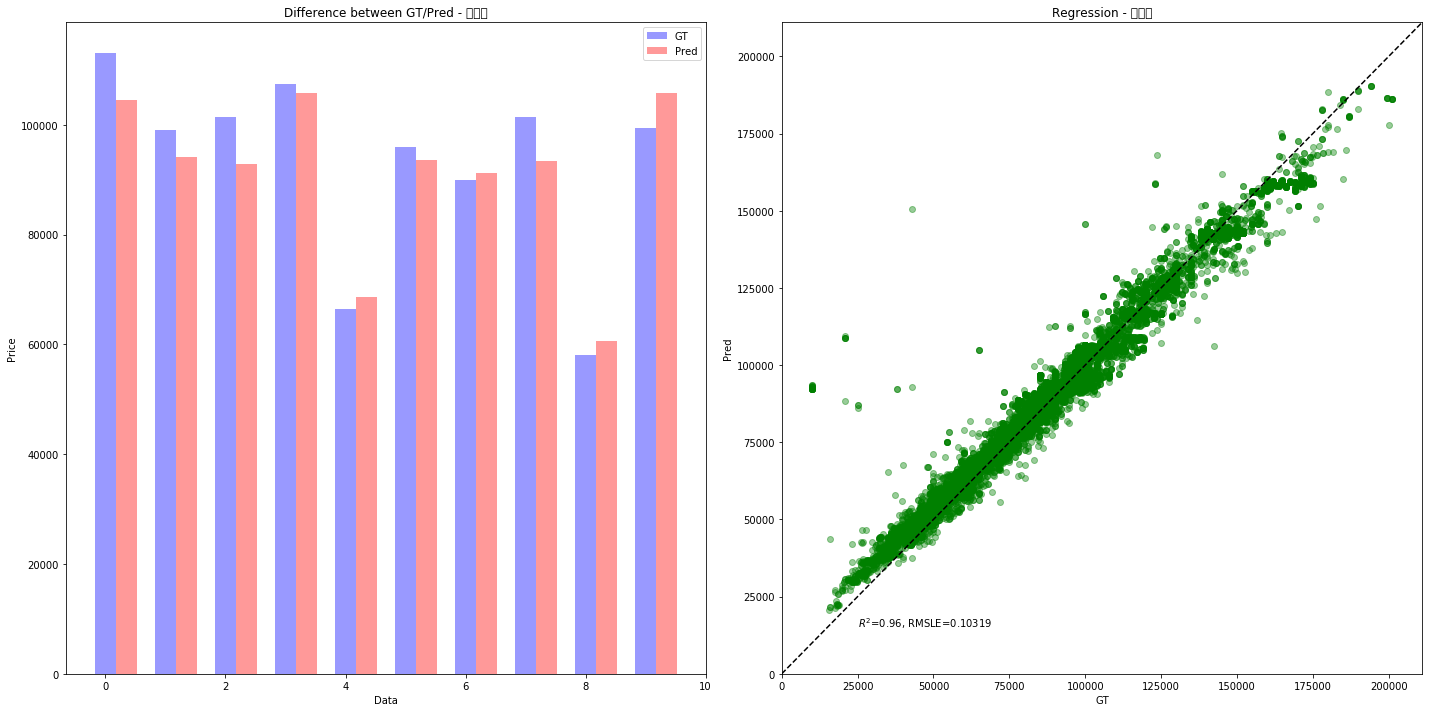

Max difference : 107585.36 만원
Mean difference : 3782.91 만원
--------
Avg Price of 송파구: 93898.26 만원
--------
R2 Coefficient : 0.963
RMLSE loss : 0.1032
MAPE : 5.6613


In [37]:
y_pred, diff = prediction_plot(10)